# Visual Question Answering (VQA) System with LoRA Fine-Tuned BLIP-2

This notebook implements a VQA system using the BLIP-2 model (`Salesforce/blip2-opt-2.7b`) fine-tuned with Low-Rank Adaptation (LoRA) on the dataset at `/kaggle/input/vr-project-json/vqa_training_data_complete.json`. It processes images and questions, generates one-word answers, and evaluates performance using metrics like Exact Match, Token Match, WUP Score, F1 Score, and BERTScore. The system leverages mixed precision training, gradient checkpointing, and the `accelerate` library for efficiency.

## Objectives
- Load and preprocess image metadata and VQA dataset.
- Split data into training (80%) and validation (20%) sets.
- Fine-tune BLIP-2 using LoRA with a custom dataset, mixed precision, and distributed training.
- Run inference to generate one-word answers on the validation set.
- Evaluate predictions with comprehensive metrics, including yes/no question analysis.
- Perform error analysis and visualize results, including answer length comparisons.

## Prerequisites
- Python libraries: `torch`, `transformers`, `peft`, `pandas`, `numpy`, `Pillow`, `nltk`, `sklearn`, `tqdm`, `matplotlib`, `seaborn`, `accelerate`.
- NLTK data: `wordnet`, `punkt`, `averaged_perceptron_tagger`, `averaged_perceptron_tagger_eng`.
- Dataset: Images and a JSON file with VQA questions and answers.
- Hardware: GPU required (CUDA support) for fine-tuning and inference.

In [ ]:
import os
import json
import csv
import torch
import numpy as np
from PIL import Image
from transformers import Blip2Processor, Blip2ForConditionalGeneration, BertTokenizer, BertModel
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score
import nltk
from nltk.corpus import wordnet as wn
from collections import Counter
import re
from sklearn.model_selection import train_test_split
from peft import LoraConfig, get_peft_model
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from accelerate import Accelerator

import warnings
warnings.filterwarnings("ignore")

# Set environment variable to reduce memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Clear GPU memory
torch.cuda.empty_cache()

# Define paths
IMAGE_BASE_DIR = r"/kaggle/input/vr-project-images/images/small"
VQA_DATA_FILE = "/kaggle/input/vr-project-json/vqa_training_data_complete.json"
# VQA_DATA_FILE = "/kaggle/input/vr-project-temp-json/temp.json"
INPUT_IMAGES_FILE = "/kaggle/input/vr-project-images/images/metadata/images.csv"
OUTPUT_RESULTS_FILE = "/kaggle/working/vqa_results.csv"
OUTPUT_METRICS_FILE = "/kaggle/working/vqa_metrics.json"
FINETUNED_MODEL_DIR = "/kaggle/working/blip2_lora_finetuned"

# Make sure necessary NLTK packages are downloaded
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

## Custom Dataset and Collate Function

We define:
- **`VQADataset`**: A PyTorch `Dataset` class that loads VQA data, processes images and questions, and tokenizes answers as labels.
- **`custom_collate_fn`**: Pads inputs (`pixel_values`, `input_ids`, `attention_mask`) and labels for batched training.

These ensure efficient data handling for BLIP-2’s requirements.

In [ ]:
class VQADataset(Dataset):
    def __init__(self, vqa_data, image_map, processor, image_base_dir):
        self.vqa_data = vqa_data
        self.image_map = image_map
        self.processor = processor
        self.image_base_dir = image_base_dir

    def __len__(self):
        total = 0
        for item in self.vqa_data:
            total += len(item["questions"])
        return total

    def __getitem__(self, idx):
        current_idx = 0
        for item in self.vqa_data:
            for q_item in item["questions"]:
                if current_idx == idx:
                    image_id = item["image_id"]
                    question = q_item["question"]
                    answer = q_item["answer"]
                    
                    image_path = os.path.join(self.image_base_dir, self.image_map[image_id]["path"])
                    if not os.path.exists(image_path):
                        raise FileNotFoundError(f"Image not found at {image_path}")
                    image = Image.open(image_path).convert('RGB')
                    
                    # Process inputs without squeezing
                    inputs = self.processor(images=image, text=question, return_tensors="pt", padding=True)
                    inputs["labels"] = self.processor.tokenizer.encode(
                        answer, return_tensors="pt", padding=True, truncation=True, max_length=20
                    )
                    
                    return inputs
                current_idx += 1
        raise IndexError("Index out of range")

# Custom collate function to pad tensors
def custom_collate_fn(batch, processor):
    """Custom collate function to pad inputs and labels to the same length."""
    pixel_values = torch.stack([item["pixel_values"].squeeze(0) for item in batch])
    input_ids = [item["input_ids"].squeeze(0) for item in batch]
    attention_mask = [item["attention_mask"].squeeze(0) for item in batch]
    labels = [item["labels"].squeeze(0) for item in batch]
    
    # Pad input_ids, attention_mask, and labels
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=processor.tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-100)  # Use -100 for ignored indices in loss
    
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

## Data Loading

The following functions load data:
- `load_image_metadata`: Reads image metadata from a CSV into a dictionary mapping image IDs to properties.
- `load_vqa_data`: Loads the VQA dataset from `vqa_training_data_complete.json`.

These support training, validation, and inference.

In [1]:
def load_image_metadata():
    """Load image metadata from CSV into a dictionary."""
    image_map = {}
    with open(INPUT_IMAGES_FILE, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            image_map[row["image_id"]] = {
                "height": int(row["height"]),
                "width": int(row["width"]),
                "path": row["path"]
            }
    return image_map

def load_vqa_data():
    """Load the VQA dataset from JSON."""
    with open(VQA_DATA_FILE, "r", encoding="utf-8") as f:
        vqa_data = json.load(f)
    return vqa_data

## Model Setup and LoRA Configuration

The system uses:
- **BLIP-2 (`Salesforce/blip2-opt-2.7b`)**: Fine-tuned with LoRA, mixed precision, and gradient checkpointing.
- **BERT (`bert-base-uncased`)**: For BERTScore calculation.
- **Accelerator**: Manages distributed training and mixed precision.

Key functions:
- `setup_vqa_model`: Initializes BLIP-2 with `float16` and device mapping.
- `configure_lora`: Applies LoRA to `q_proj`, `v_proj`, `k_proj` modules with a custom forward method.
- `train_model`: Fine-tunes BLIP-2 using mixed precision, gradient scaling, and `accelerate`.
- `setup_bertscore_model`: Initializes BERT for evaluation.

In [ ]:
def setup_vqa_model():
    """Initialize the BLIP-2 model and processor with memory optimizations."""
    accelerator = Accelerator(mixed_precision="fp16")
    processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
    
    model = Blip2ForConditionalGeneration.from_pretrained(
        "Salesforce/blip2-opt-2.7b", 
        torch_dtype=torch.float16,
        device_map="auto"
    )
    
    model.gradient_checkpointing_enable()
    
    # Print forward method documentation for verification
    print("Blip2ForConditionalGeneration.forward documentation:")
    # print(model.forward.__doc__)
    
    device = accelerator.device
    return processor, model, device, accelerator

def configure_lora(model):
    """Configure LoRA for the BLIP-2 model with a custom forward wrapper for base_model."""
    lora_config = LoraConfig(
        r=16,
        lora_alpha=16,
        target_modules=["q_proj", "v_proj", "k_proj"],
        lora_dropout=0.1,
        bias="none",
        task_type="QUESTION_ANS"
    )
    model = get_peft_model(model, lora_config)
    
    # Store the original base_model forward method
    original_base_forward = model.base_model.forward
    
    # Define a custom forward method to filter out inputs_embeds
    def custom_base_forward(self, *args, **kwargs):
        # Debug: Log arguments before filtering
        # print("Base model forward kwargs before filtering:", kwargs.keys())
        # Filter out inputs_embeds and other unsupported arguments
        supported_kwargs = {
            k: v for k, v in kwargs.items()
            if k in [
                "pixel_values", "input_ids", "attention_mask", "labels",
                "decoder_input_ids", "decoder_attention_mask",
                "output_attentions", "output_hidden_states", "return_dict",
                "interpolate_pos_encoding", "use_cache"
            ]
        }
        # Debug: Log arguments after filtering
        # print("Base model forward kwargs after filtering:", supported_kwargs.keys())
        return original_base_forward(*args, **supported_kwargs)
    
    # Bind the custom forward method to the base_model
    import types
    model.base_model.forward = types.MethodType(custom_base_forward, model.base_model)
    
    model.print_trainable_parameters()
    return model

def train_model(model, processor, train_loader, val_loader, device, accelerator, num_epochs=3, lr=5e-5):
    """Fine-tune the model with LoRA and mixed precision."""
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scaler = GradScaler()
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        total_loss = 0
        model.train()
        for batch in tqdm(train_loader, desc="Training"):
            # Debug: Print batch keys to verify contents
            # print("Batch keys:", batch.keys())
            # Filter batch to include only supported arguments for BLIP-2
            batch = {
                k: v for k, v in batch.items()
                if k in ["pixel_values", "input_ids", "attention_mask", "labels"]
            }
            with autocast():
                outputs = model(**batch)
                loss = outputs.loss
            
            accelerator.backward(scaler.scale(loss))
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss:.4f}")
        
        # # Validation
        # model.eval()
        # val_loss = 0
        # with torch.no_grad():
        #     for batch in tqdm(val_loader, desc="Validation"):
        #         # Debug: Print batch keys
        #         # print("Validation batch keys:", batch.keys())
        #         # Filter batch for validation
        #         batch = {
        #             k: v for k, v in batch.items()
        #             if k in ["pixel_values", "input_ids", "attention_mask", "labels"]
        #         }
        #         with autocast():
        #             outputs = model(**batch)
        #             val_loss += outputs.loss.item()
        
        # avg_val_loss = val_loss / len(val_loader)
        # print(f"Average Validation Loss: {avg_val_loss:.4f}")
    
    accelerator.unwrap_model(model).save_pretrained(FINETUNED_MODEL_DIR)
    processor.save_pretrained(FINETUNED_MODEL_DIR)
    print(f"Fine-tuned model saved to {FINETUNED_MODEL_DIR}")

def setup_bertscore_model():
    """Initialize models for BERTScore calculation."""
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return tokenizer, model, device

## Answer Normalization and Evaluation Metrics

We normalize answers and compute:
- **Normalization** (`normalize_answer`): Converts numbers to words, removes articles and punctuation, and standardizes whitespace.
- **Exact Match** (`exact_match`): Checks if normalized answers are identical.
- **Token Match** (`token_match`): Compares token sets for exact overlap.
- **Wu-Palmer Similarity** (`calculate_wup_score`): Measures semantic similarity using WordNet.
- **F1 Score** (`calculate_f1_score`): Computes token-based precision, recall, and F1 score.
- **BERTScore** (`calculate_bertscore`): Evaluates semantic similarity using BERT embeddings.

In [4]:
def normalize_answer(s):
    """Normalize answer for more accurate comparison."""
    # Define reversed number map (digits to words)
    number_map = {
        '0': 'zero', '1': 'one', '2': 'two', '3': 'three', '4': 'four',
        '5': 'five', '6': 'six', '7': 'seven', '8': 'eight', '9': 'nine', '10': 'ten'
    }
    
    # Convert digits to words
    for digit, word in number_map.items():
        s = re.sub(r'\b' + digit + r'\b', word, s.lower())
    
    # Remove articles
    s = re.sub(r'\b(a|an|the)\b', ' ', s)
    # Remove punctuation and extra whitespace
    s = re.sub(r'[^\w\s]', '', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def calculate_bertscore(pred, ref, tokenizer, model, device):
    """Calculate BERTScore between prediction and reference."""
    pred_tokens = tokenizer(pred, return_tensors='pt', padding=True, truncation=True).to(device)
    ref_tokens = tokenizer(ref, return_tensors='pt', padding=True, truncation=True).to(device)
    
    with torch.no_grad():
        pred_outputs = model(**pred_tokens)
        ref_outputs = model(**ref_tokens)
    
    pred_embedding = pred_outputs.last_hidden_state[:, 0, :]
    ref_embedding = ref_outputs.last_hidden_state[:, 0, :]
    
    pred_embedding = pred_embedding / pred_embedding.norm(dim=1, keepdim=True)
    ref_embedding = ref_embedding / ref_embedding.norm(dim=1, keepdim=True)
    
    similarity = torch.matmul(pred_embedding, ref_embedding.transpose(0, 1)).item()
    return similarity

def exact_match(pred, ref):
    """Check if prediction exactly matches reference after normalization."""
    return normalize_answer(pred) == normalize_answer(ref)

def token_match(pred, ref):
    """Check if the tokens in prediction match the reference."""
    pred_tokens = normalize_answer(pred).split()
    ref_tokens = normalize_answer(ref).split()
    return Counter(pred_tokens) == Counter(ref_tokens)

def get_wordnet_pos(word):
    """Map POS tag to first character used by WordNet."""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wn.ADJ, "N": wn.NOUN, "V": wn.VERB, "R": wn.ADV}
    return tag_dict.get(tag, wn.NOUN)

def calculate_wup_score(pred, ref):
    """Calculate Wu-Palmer similarity score between prediction and reference."""
    pred_tokens = normalize_answer(pred).split()
    ref_tokens = normalize_answer(ref).split()
    
    if not pred_tokens or not ref_tokens:
        return 0.0
    
    max_similarities = []
    
    for p_token in pred_tokens:
        token_max_sim = 0.0
        p_synsets = wn.synsets(p_token, pos=get_wordnet_pos(p_token))
        if not p_synsets:
            p_synsets = wn.synsets(p_token)
        if not p_synsets:
            continue
        for r_token in ref_tokens:
            r_synsets = wn.synsets(r_token, pos=get_wordnet_pos(r_token))
            if not r_synsets:
                r_synsets = wn.synsets(r_token)
            if not r_synsets:
                continue
            token_sims = []
            for p_syn in p_synsets:
                for r_syn in r_synsets:
                    try:
                        sim = wn.wup_similarity(p_syn, r_syn)
                        if sim is not None:
                            token_sims.append(sim)
                    except:
                        continue
            if token_sims:
                token_max_sim = max(token_max_sim, max(token_sims))
        if token_max_sim > 0:
            max_similarities.append(token_max_sim)
    
    return sum(max_similarities) / len(max_similarities) if max_similarities else 0.0

def calculate_f1_score(pred, ref):
    """Calculate F1 score between prediction and reference tokens."""
    pred_tokens = set(normalize_answer(pred).split())
    ref_tokens = set(normalize_answer(ref).split())
    
    if not pred_tokens and not ref_tokens:
        return 1.0
    if not pred_tokens or not ref_tokens:
        return 0.0
    
    common_tokens = pred_tokens.intersection(ref_tokens)
    precision = len(common_tokens) / len(pred_tokens)
    recall = len(common_tokens) / len(ref_tokens)
    
    if precision + recall == 0:
        return 0.0
    
    f1 = 2 * precision * recall / (precision + recall)
    return f1

## Running Inference

The `run_inference` function processes the validation dataset:
- Uses the fine-tuned BLIP-2 model to generate one-word answers with the prompt `Question: {question} Answer in one word:`.
- Applies beam search (`num_beams=3`) and `max_new_tokens=1` for concise outputs.
- Computes evaluation metrics and saves results to a CSV file.
- Includes error handling for missing images or processing issues.

In [5]:
def run_inference(model, processor, device, vqa_data, image_map):
    bert_tokenizer, bert_model, bert_device = setup_bertscore_model()
    
    model.eval()
    results = []
    
    for item in tqdm(vqa_data, desc="Processing VQA items"):
        image_id = item["image_id"]
        if image_id not in image_map:
            print(f"Warning: Image ID {image_id} not found in metadata. Skipping.")
            continue
        
        image_path = os.path.join(IMAGE_BASE_DIR, image_map[image_id]["path"])
        if not os.path.exists(image_path):
            print(f"Warning: Image file not found at {image_path}. Skipping.")
            continue
        
        try:
            image = Image.open(image_path).convert('RGB')
            for q_item in item["questions"]:
                question = q_item["question"]
                ground_truth = q_item["answer"]
                
                inputs = processor(images=image, text=f"Question: {question} Answer in one word:",padding=True,
        truncation=True, return_tensors="pt").to(device)
                
                with torch.no_grad():
                    with autocast():
                        generated_ids = model.generate(
                            **inputs,
                            max_new_tokens=1,
                            num_beams=3,
                            early_stopping=True,
                            # no_repeat_ngram_size=2
                            
                        )
                    raw_answers = processor.batch_decode(generated_ids, skip_special_tokens=True)
                    cleaned_preds = []
                    for q, ans in zip([question], raw_answers):  # Single question
                        prompt_prefix = f"Question: {q} Answer in one word:"
                        cleaned = ans.replace(prompt_prefix, "").strip().lower()
                        first_word = cleaned.split()[0] if cleaned else ""
                        cleaned_preds.append(first_word)
                    predicted_answer = cleaned_preds[0]
                    predicted_answer=normalize_answer(predicted_answer)
                
                em_score = exact_match(predicted_answer, ground_truth)
                token_match_score = token_match(predicted_answer, ground_truth)
                wup_score = calculate_wup_score(predicted_answer, ground_truth)
                f1 = calculate_f1_score(predicted_answer, ground_truth)
                bertscore = calculate_bertscore(predicted_answer, ground_truth, bert_tokenizer, bert_model, bert_device)
                
                results.append({
                    "image_id": image_id,
                    "question": question,
                    "ground_truth": normalize_answer(ground_truth),
                    "predicted_answer": predicted_answer,
                    "exact_match": em_score,
                    "token_match": token_match_score,
                    "wup_score": wup_score,
                    "f1_score": f1,
                    "bertscore": bertscore
                })
                
        except Exception as e:
            print(f"Error processing image {image_id}: {str(e)}")
    
    results_df = pd.DataFrame(results)
    results_df.to_csv(OUTPUT_RESULTS_FILE, index=False)
    return results_df

## Evaluating Results

The `evaluate_results` function analyzes inference results:
- Computes overall metrics (mean Exact Match, Token Match, WUP, F1, BERTScore).
- Categorizes questions into types (counting, color, yes/no, other).
- Analyzes yes/no questions with binary classification metrics.
- Saves metrics to a JSON file and prints a summary.

In [6]:
def evaluate_results(results_df):
    """Evaluate and print detailed metrics from the results."""
    metrics = {
        "overall": {
            "exact_match": results_df["exact_match"].mean(),
            "token_match": results_df["token_match"].mean(),
            "wup_score": results_df["wup_score"].mean(),
            "f1_score": results_df["f1_score"].mean(),
            "bertscore": results_df["bertscore"].mean()
        }
    }
    
    results_df["question_type"] = "other"
    results_df.loc[results_df["question"].str.contains("how many|number|count", case=False), "question_type"] = "counting"
    results_df.loc[results_df["question"].str.contains("color|colour", case=False), "question_type"] = "color"
    results_df.loc[results_df["question"].str.startswith(("Is ", "Are ", "Does ", "Do ", "Can ", "Could ", "Has ", "Have ")), "question_type"] = "yes/no"
    
    question_types = results_df["question_type"].unique()
    metrics["by_question_type"] = {}
    
    for qtype in question_types:
        subset = results_df[results_df["question_type"] == qtype]
        metrics["by_question_type"][qtype] = {
            "count": len(subset),
            "exact_match": subset["exact_match"].mean(),
            "token_match": subset["token_match"].mean(),
            "wup_score": subset["wup_score"].mean(),
            "f1_score": subset["f1_score"].mean(),
            "bertscore": subset["bertscore"].mean()
        }
    
    yes_no_df = results_df[results_df["question_type"] == "yes/no"]
    if len(yes_no_df) > 0:
        yes_no_df["gt_binary"] = yes_no_df["ground_truth"].str.lower().apply(
            lambda x: 1 if x in ["yes", "yeah", "true"] else 0)
        yes_no_df["pred_binary"] = yes_no_df["predicted_answer"].str.lower().apply(
            lambda x: 1 if x in ["yes", "yeah", "true"] else 0)
        
        metrics["yes_no_analysis"] = {
            "accuracy": (yes_no_df["gt_binary"] == yes_no_df["pred_binary"]).mean(),
            "precision": precision_score(yes_no_df["gt_binary"], yes_no_df["pred_binary"], zero_division=0),
            "recall": recall_score(yes_no_df["gt_binary"], yes_no_df["pred_binary"], zero_division=0),
            "f1": f1_score(yes_no_df["gt_binary"], yes_no_df["pred_binary"], zero_division=0)
        }
    
    with open(OUTPUT_METRICS_FILE, 'w') as f:
        json.dump(metrics, f, indent=2)
    
    print("\n===== VQA Evaluation Results =====")
    print(f"Total questions evaluated: {len(results_df)}")
    print(f"Exact match accuracy: {metrics['overall']['exact_match']:.4f}")
    print(f"Token match accuracy: {metrics['overall']['token_match']:.4f}")
    print(f"Average WUP score: {metrics['overall']['wup_score']:.4f}")
    print(f"Average F1 score: {metrics['overall']['f1_score']:.4f}")
    print(f"Average BERTScore: {metrics['overall']['bertscore']:.4f}")
    
    print("\n===== Results by Question Type =====")
    for qtype, qmetrics in metrics["by_question_type"].items():
        print(f"\n{qtype.upper()} Questions ({qmetrics['count']} questions):")
        print(f"  Exact match: {qmetrics['exact_match']:.4f}")
        print(f"  Token match: {qmetrics['token_match']:.4f}")
        print(f"  WUP score: {qmetrics['wup_score']:.4f}")
        print(f"  F1 score: {qmetrics['f1_score']:.4f}")
        print(f"  BERTScore: {qmetrics['bertscore']:.4f}")
    
    if "yes_no_analysis" in metrics:
        print("\n===== Yes/No Question Analysis =====")
        print(f"  Accuracy: {metrics['yes_no_analysis']['accuracy']:.4f}")
        print(f"  Precision: {metrics['yes_no_analysis']['precision']:.4f}")
        print(f"  Recall: {metrics['yes_no_analysis']['recall']:.4f}")
        print(f"  F1 score: {metrics['yes_no_analysis']['f1']:.4f}")
    
    return metrics

## Error Analysis

The `run_error_analysis` function identifies failure cases:
- Finds the 10 worst-performing questions based on averaged metrics.
- Analyzes error rates by question type.
- Examines correlation between ground truth answer length and accuracy.
- Studies F1 score distribution.

In [7]:
def run_error_analysis(results_df):
    """Perform detailed error analysis on the results."""
    results_df["avg_score"] = (
        results_df["exact_match"] + 
        results_df["token_match"] + 
        results_df["wup_score"] + 
        results_df["f1_score"] + 
        results_df["bertscore"]
    ) / 5
    
    worst_cases = results_df.sort_values("avg_score").head(10)
    
    print("\n===== Worst Performing Cases =====")
    for i, (_, row) in enumerate(worst_cases.iterrows()):
        print(f"\nCase {i+1}:")
        print(f"Image ID: {row['image_id']}")
        print(f"Question: {row['question']}")
        print(f"Ground Truth: {row['ground_truth']}")
        print(f"Prediction: {row['predicted_answer']}")
        print(f"Metrics: EM={row['exact_match']}, TM={row['token_match']}, WUP={row['wup_score']:.4f}, "
              f"F1={row['f1_score']:.4f}, BERTScore={row['bertscore']:.4f}")
    
    error_df = results_df[~results_df["exact_match"]]
    
    results_df["gt_length"] = results_df["ground_truth"].apply(len)
    results_df["pred_length"] = results_df["predicted_answer"].apply(len)
    results_df["length_diff"] = abs(results_df["pred_length"] - results_df["gt_length"])
    
    error_by_qtype = error_df.groupby("question_type").size()
    total_by_qtype = results_df.groupby("question_type").size()
    error_rate_by_qtype = (error_by_qtype / total_by_qtype).fillna(0)
    
    print("\n===== Error Analysis by Question Type =====")
    for qtype, error_rate in error_rate_by_qtype.items():
        print(f"{qtype}: {error_rate:.4f} error rate ({error_by_qtype[qtype]} errors out of {total_by_qtype[qtype]} questions)")
    
    corr = results_df["gt_length"].corr(results_df["exact_match"])
    print(f"\nCorrelation between answer length and accuracy: {corr:.4f}")
    
    f1_ranges = [(0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
    f1_distribution = {}
    
    for low, high in f1_ranges:
        count = ((results_df["f1_score"] >= low) & (results_df["f1_score"] < high)).sum()
        f1_distribution[f"{low}-{high}"] = count
    
    perfect_f1 = (results_df["f1_score"] == 1.0).sum()
    f1_distribution["1.0"] = perfect_f1
    
    print("\n===== F1 Score Distribution =====")
    for range_name, count in f1_distribution.items():
        percentage = count / len(results_df) * 100
        print(f"F1 Score {range_name}: {count} questions ({percentage:.2f}%)")
    
    return {
        "worst_cases": worst_cases,
        "error_by_qtype": error_by_qtype,
        "error_rate_by_qtype": error_rate_by_qtype,
        "length_correlation": corr,
        "f1_distribution": f1_distribution
    }

## Visualizing Metrics

The `visualize_metrics` function creates:
- Histograms of F1, WUP, and BERTScore distributions.
- Count plot of Exact Match results.
- Boxplots of metrics by question type.
- Scatter plot comparing ground truth and predicted answer lengths.
- Saves plots as `metric_distributions.png`, `metrics_by_question_type.png`, and `answer_length_comparison.png`.

**Note**: Requires `matplotlib` and `seaborn`.

In [8]:
def visualize_metrics(results_df):
    """Create visualizations of the evaluation metrics."""
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        sns.set_style("whitegrid")
        
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 2, 1)
        sns.histplot(data=results_df, x="f1_score", bins=20, kde=True)
        plt.title("Distribution of F1 Scores")
        plt.xlabel("F1 Score")
        plt.ylabel("Frequency")
        
        plt.subplot(2, 2, 2)
        sns.histplot(data=results_df, x="wup_score", bins=20, kde=True)
        plt.title("Distribution of WUP Scores")
        plt.xlabel("WUP Score")
        plt.ylabel("Frequency")
        
        plt.subplot(2, 2, 3)
        sns.histplot(data=results_df, x="bertscore", bins=20, kde=True)
        plt.title("Distribution of BERTScores")
        plt.xlabel("BERTScore")
        plt.ylabel("Frequency")
        
        plt.subplot(2, 2, 4)
        sns.countplot(data=results_df, x="exact_match")
        plt.title("Exact Match Counts")
        plt.xlabel("Exact Match (0=No, 1=Yes)")
        plt.ylabel("Count")
        
        plt.tight_layout()
        plt.savefig("metric_distributions.png")
        
        plt.figure(figsize=(15, 10))
        metrics = ["f1_score", "wup_score", "bertscore"]
        
        for i, metric in enumerate(metrics):
            plt.subplot(1, 3, i+1)
            sns.boxplot(data=results_df, x="question_type", y=metric)
            plt.title(f"{metric} by Question Type")
            plt.xlabel("Question Type")
            plt.ylabel(metric)
            plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.savefig("metrics_by_question_type.png")
        
        plt.figure(figsize=(10, 6))
        plt.scatter(results_df["gt_length"], results_df["pred_length"], alpha=0.5)
        plt.title("BLIP-2 Answer Length vs Ground Truth Answer Length")
        plt.xlabel("Ground Truth Answer Length")
        plt.ylabel("BLIP-2 Answer Length")
        plt.plot([0, results_df["gt_length"].max()], [0, results_df["gt_length"].max()], 'r--')
        plt.tight_layout()
        plt.savefig("answer_length_comparison.png")
        
        print("\nVisualization images saved as 'metric_distributions.png', 'metrics_by_question_type.png', and 'answer_length_comparison.png'")
        
    except ImportError:
        print("\nNote: matplotlib and seaborn are required for visualization. Install with: pip install matplotlib seaborn")

## Main Execution

The main block runs the pipeline:
1. Loads and splits data into training and validation sets.
2. Sets up and fine-tunes BLIP-2 with LoRA and mixed precision.
3. Runs inference on the validation set for one-word answers.
4. Evaluates results and performs error analysis.
5. Generates visualizations.
6. Saves outputs and the fine-tuned model.

2025-05-14 11:38:42.295612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747222722.492962      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747222722.549179      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_da

Starting VQA fine-tuning and evaluation process with BLIP-2 and LoRA...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

Blip2ForConditionalGeneration.forward documentation:
trainable params: 3,932,160 || all params: 3,748,694,016 || trainable%: 0.1049
Epoch 1/3


Training: 100%|██████████| 9732/9732 [58:45<00:00,  2.76it/s]


Average Training Loss: 2.5252
Epoch 2/3


Training: 100%|██████████| 9732/9732 [57:33<00:00,  2.82it/s]


Average Training Loss: 1.9718
Epoch 3/3


Training: 100%|██████████| 9732/9732 [57:56<00:00,  2.80it/s]


Average Training Loss: 1.7587
Fine-tuned model saved to /kaggle/working/blip2_lora_finetuned


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Processing VQA items:   0%|          | 0/1774 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
The `language_model` is not in the `hf_device_map` dictionary and you are running your script in a multi-GPU environment. this may lead to unexpected behavior when using `accelerate`. Please pass a `device_map` that contains `language_model` to remove this warning. Please refer to https://github.com/huggingface/blog/blob/main/accelerate-large-models.md for more details on creating a `device_map` for large models.
The `language_model` is not in the `hf_device_map` dictionary and you are running your script in a multi-GPU environment. this may lead to unexpected behavior when using `accelerate`. Please pass a `device_map` that contains `language_model` to remove this warning. Please refer to https://github.com/huggingface/blog/blob/main/accelerate-large-models.md for more details on creat


===== VQA Evaluation Results =====
Total questions evaluated: 4848
Exact match accuracy: 0.5452
Token match accuracy: 0.5452
Average WUP score: 0.6909
Average F1 score: 0.5461
Average BERTScore: 0.9582

===== Results by Question Type =====

COLOR Questions (1577 questions):
  Exact match: 0.6487
  Token match: 0.6487
  WUP score: 0.7911
  F1 score: 0.6487
  BERTScore: 0.9750

YES/NO Questions (1195 questions):
  Exact match: 0.7481
  Token match: 0.7481
  WUP score: 0.8000
  F1 score: 0.7481
  BERTScore: 0.9800

OTHER Questions (1441 questions):
  Exact match: 0.2734
  Token match: 0.2734
  WUP score: 0.4025
  F1 score: 0.2767
  BERTScore: 0.9162

COUNTING Questions (635 questions):
  Exact match: 0.5228
  Token match: 0.5228
  WUP score: 0.8909
  F1 score: 0.5228
  BERTScore: 0.9704

===== Yes/No Question Analysis =====
  Accuracy: 0.9448
  Precision: 0.9474
  Recall: 0.9443
  F1 score: 0.9458

===== Worst Performing Cases =====

Case 1:
Image ID: 81sFvxfaQtL
Question: What type of c

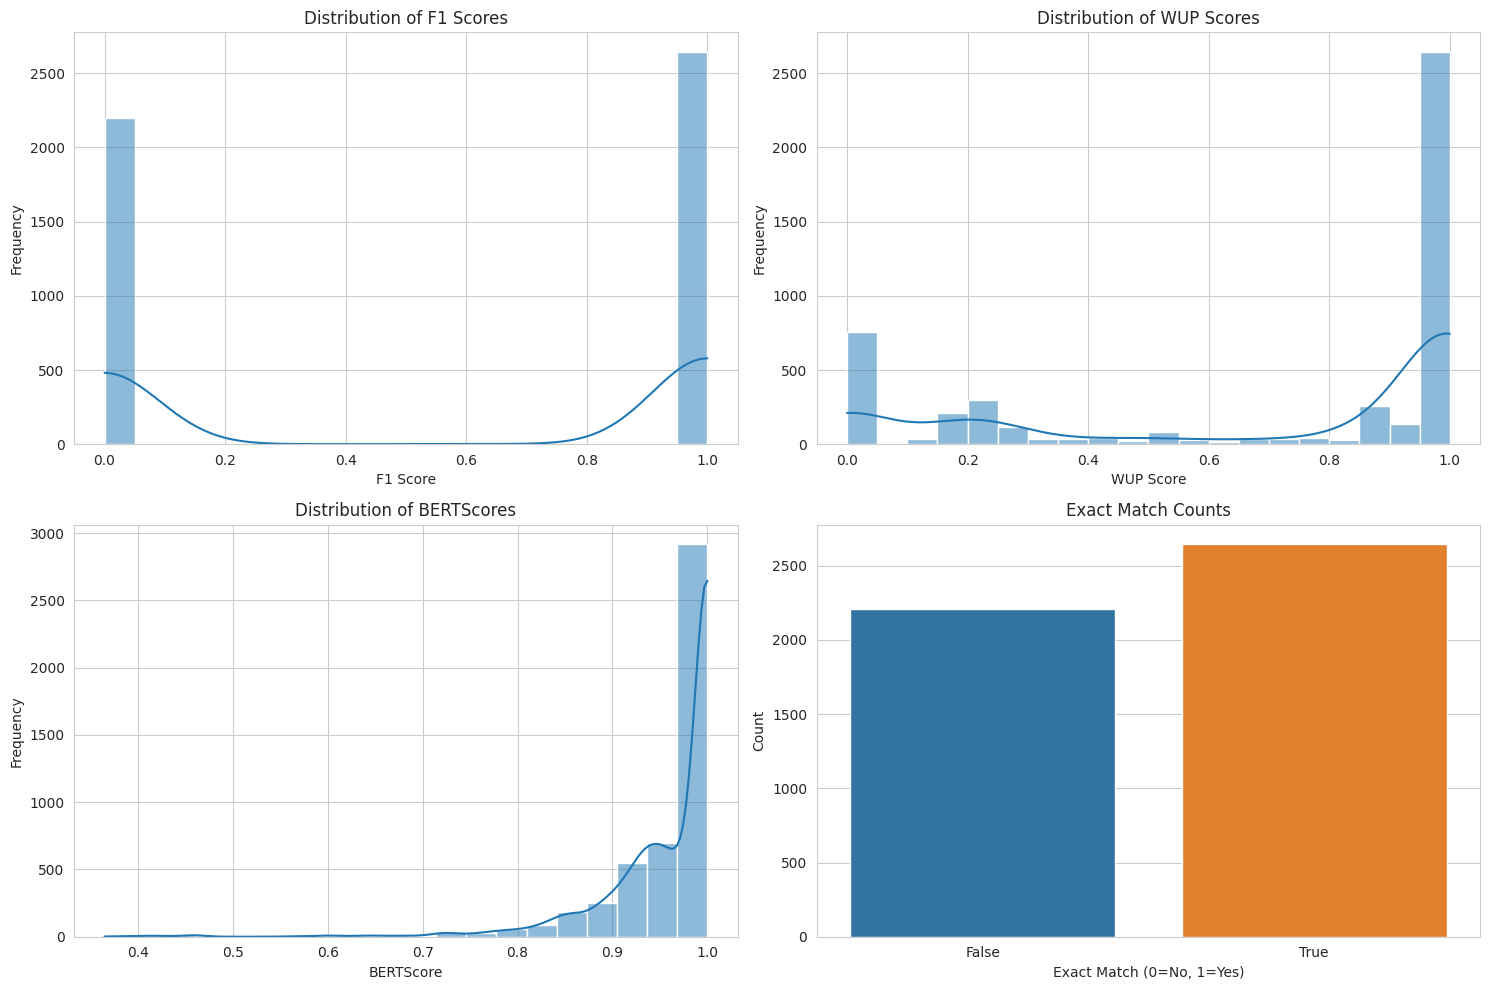

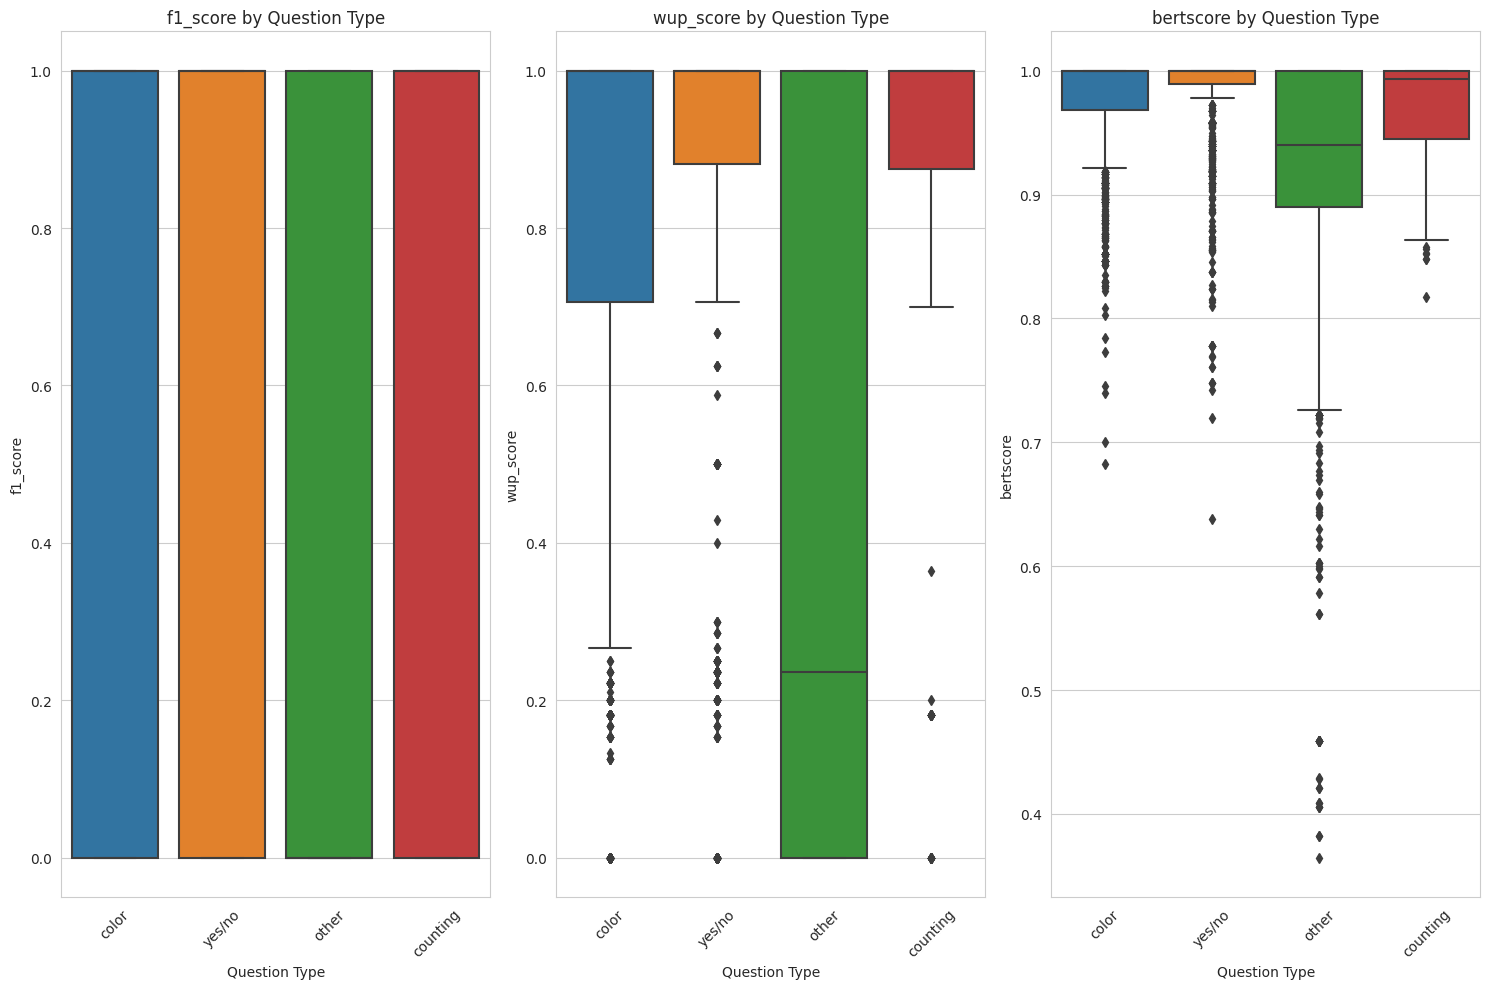

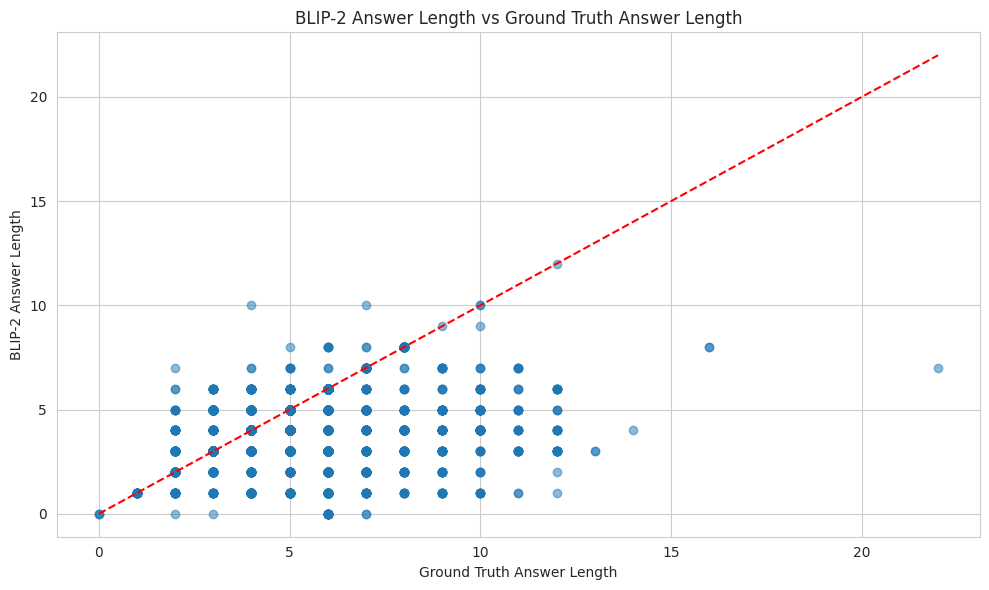

In [ ]:
if __name__ == "__main__":
    print("Starting VQA fine-tuning and evaluation process with BLIP-2 and LoRA...")
    
    # Load data
    image_map = load_image_metadata()
    vqa_data = load_vqa_data()
    
    # Split dataset into train and validation
    train_data, val_data = train_test_split(vqa_data, test_size=0.2, random_state=42)
    
    # Setup model and processor
    processor, model, device, accelerator = setup_vqa_model()
    
    # Configure LoRA with custom forward wrapper
    model = configure_lora(model)
    
    # Create datasets and dataloaders with custom collate function
    train_dataset = VQADataset(train_data, image_map, processor, IMAGE_BASE_DIR)
    val_dataset = VQADataset(val_data, image_map, processor, IMAGE_BASE_DIR)
    train_loader = DataLoader(
        train_dataset, 
        batch_size=2, 
        shuffle=True, 
        num_workers=0, 
        collate_fn=lambda batch: custom_collate_fn(batch, processor)
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=2, 
        shuffle=False, 
        num_workers=0, 
        collate_fn=lambda batch: custom_collate_fn(batch, processor)
    )
    
    # Fine-tune the model
    train_model(model, processor, train_loader, val_loader, device, accelerator, num_epochs=3, lr=5e-5)
    
    # Setup BERTScore model once
    bert_tokenizer, bert_model, bert_device = setup_bertscore_model()
    
    # Run inference with fine-tuned model on validation set only
    results = run_inference(model, processor, device, val_data, image_map)
    
    # Evaluate results
    metrics = evaluate_results(results)
    
    # Perform error analysis
    error_analysis = run_error_analysis(results)
    
    # Visualize metrics
    visualize_metrics(results)
    
    print(f"\nResults saved to {OUTPUT_RESULTS_FILE}")
    print(f"Detailed metrics saved to {OUTPUT_METRICS_FILE}")
    print(f"Fine-tuned model saved to {FINETUNED_MODEL_DIR}")